In [1]:
# Import Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [2]:
# Create a function to return the Pearson Correlation coefficient given two variables
def pearson_r(x, y):
    """Compute Pearson correlation coefficient between two arrays."""
    # Compute correlation matrix: corr_mat
    corr_mat = np.corrcoef(x,y)

    # Return entry [0,1]
    return corr_mat[0,1]

In [3]:
# Import the dataset
df = pd.read_csv('https://assets.datacamp.com/production/repositories/470/datasets/f1e7f8a98c18da5c60b625cb8af04c3217f4a5c3/female_literacy_fertility.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162 entries, 0 to 161
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Country          162 non-null    object 
 1   Continent        162 non-null    object 
 2   female literacy  162 non-null    float64
 3   fertility        162 non-null    float64
 4   population       162 non-null    object 
dtypes: float64(2), object(3)
memory usage: 6.5+ KB


In [8]:
df.columns

Index(['Country ', 'Continent', 'female literacy', 'fertility', 'population'], dtype='object')

In [9]:
# Create illiteracy column
df['illiteracy'] = 100 - df['female literacy']

In [10]:
df.head()

,Country,Continent,female literacy,fertility,population,illiteracy
0,Chine,ASI,90.5,1.769,"1,324,655,000",9.5
1,Inde,ASI,50.8,2.682,"1,139,964,932",49.2
2,USA,NAM,99.0,2.077,"304,060,000",1.0
3,Indonésie,ASI,88.8,2.132,"227,345,082",11.2
4,Brésil,LAT,90.2,1.827,"191,971,506",9.8


In [11]:
illiteracy = df.illiteracy

In [12]:
fertility = df.fertility

Text(0, 0.5, 'fertility')

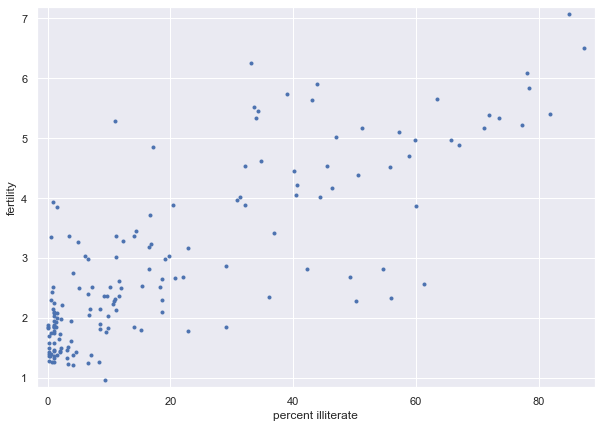

In [16]:
# Plot the illiteracy rate versus fertility
sns.set()
fig, ax = plt.subplots(figsize=(10,7))
plt.plot(illiteracy, fertility, marker='.', linestyle='none')

# Set the margins and label axes
plt.margins(0.02)
plt.xlabel('percent illiterate')
plt.ylabel('fertility')

In [17]:
# Show the Pearson correlation coefficient
print(f"Pearson coeff: {pearson_r(illiteracy, fertility)}")

Pearson coeff: 0.8041324026815344


You can see the correlation between illiteracy and fertility by eye, and by the substantial Pearson correlation coefficient of 0.8. It is difficult to resolve in the scatter plot, but there are many points around near-zero illiteracy and about 1.8 children/woman

## Linear Regression using numpy

In [18]:
# Perform a linear regression using np.polyfit(): a, b
a, b = np.polyfit(illiteracy, fertility, 1)

# Print the results to the screen
print('slope =', a, 'children per woman / percent illiterate')
print('intercept =', b, 'children per woman')

slope = 0.04979854809063423 children per woman / percent illiterate
intercept = 1.888050610636557 children per woman


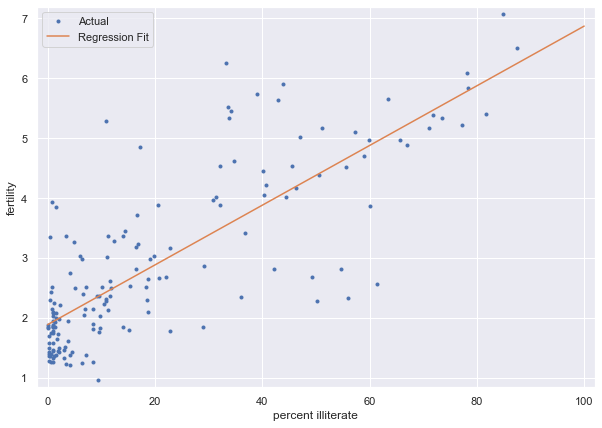

In [22]:
# Plot the illiteracy rate versus fertility
fig, ax = plt.subplots(figsize=(10,7))
plt.plot(illiteracy, fertility, marker='.', linestyle='none', label='Actual')
plt.margins(0.02)
plt.xlabel('percent illiterate')
plt.ylabel('fertility')

# Make theoretical line to plot
x = np.array([0,100])
y = a * x + b

# Add regression line to your plot
plt.plot(x, y, label='Regression Fit')
plt.legend()